In [3]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.ndimage import zoom
import cv2
from skimage import exposure
import os

In [4]:
audio_path = os.path.join("test_audio", "4.wav")
y, sr = librosa.load(audio_path)

In [5]:
N_FFT = 4096
WINDOW = 'hamming'
WIN_LENGTH = N_FFT//2
HOP_LENGTH = WIN_LENGTH//4

# GRIFFIN LIM signal reconstruction with no phase information

In [6]:
D = librosa.stft(y, n_fft=N_FFT, window=WINDOW, win_length=WIN_LENGTH, hop_length=HOP_LENGTH)
S = np.abs(D)

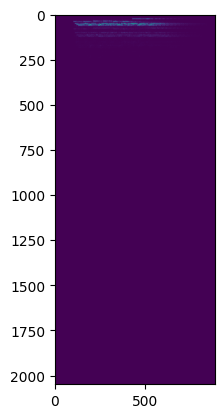

In [7]:
plt.imshow(S)

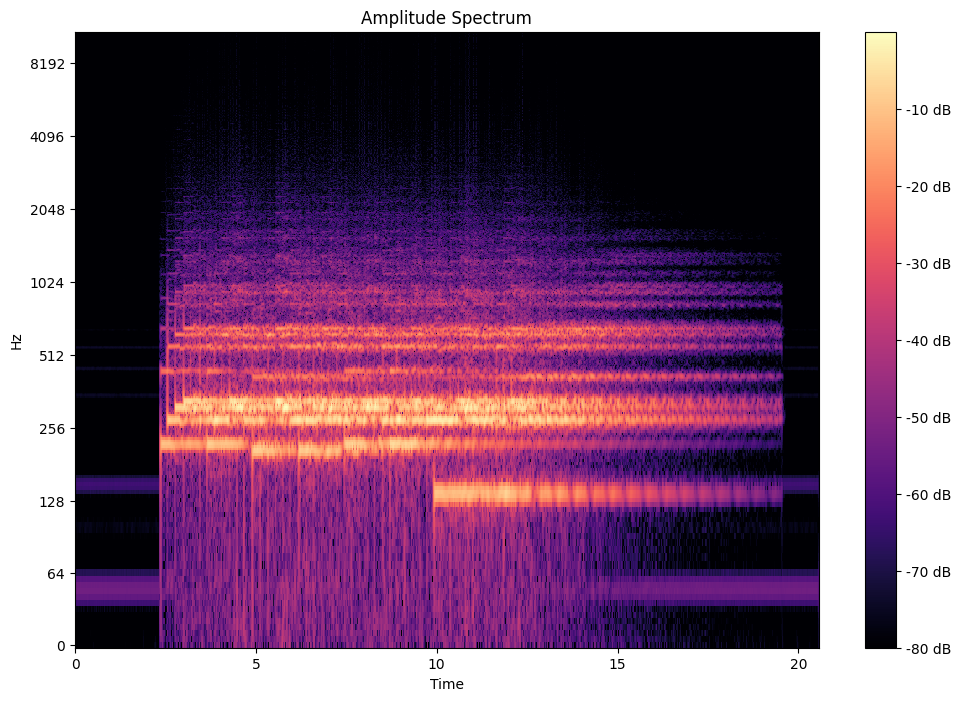

In [8]:
plt.figure(figsize=(12, 8))
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Amplitude Spectrum')
plt.show()

In [9]:
y_inv = librosa.griffinlim(S, win_length=WIN_LENGTH, n_fft=N_FFT, window=WINDOW, hop_length=HOP_LENGTH)

In [10]:
# Function to calculate Signal-to-Noise Ratio (SNR)
def calculate_snr(original, reconstructed):
    signal_power = np.sum(original**2)
    noise_power = np.sum((original - reconstructed)**2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

In [11]:
# Calculate the difference metric
reconstructed_audio = librosa.util.fix_length(y_inv, size=y.shape[0])
difference_metric = calculate_snr(y, reconstructed_audio)

print(f"Difference Metric : {difference_metric}")

Difference Metric : -3.3690589666366577


the temporal missalignment leads to this metric not working well but if you listen to the reconstruction it sounds very good.

In [12]:
sf.write('./../data/output_audio/which_inv_griffin_lim.wav', y_inv, sr, subtype='PCM_24')


# Canny preprocessing + griffin LIM

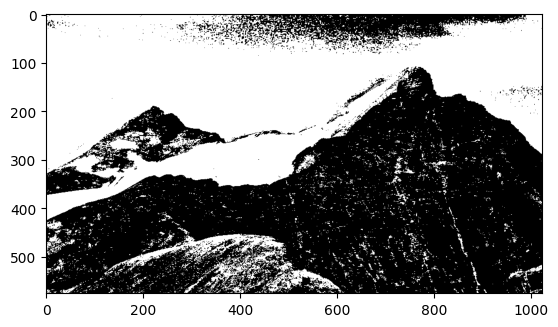

In [13]:
image = cv2.imread('../data/input_images/grande_sassiere.jpg')
imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 90, 255, 0)
plt.imshow(thresh, cmap='gray')


size of the image (576, 1024)


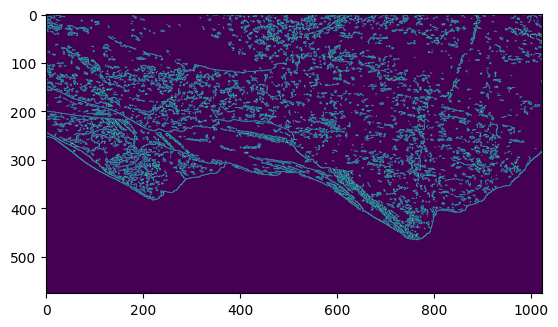

In [14]:
edges = cv2.Canny(image, threshold1=100, threshold2=150)
plt.imshow(cv2.flip(edges, 0))
print(f'size of the image {edges.shape}')

We would like to produce from this image a 5 seconds audio at 24khz sample rate. This means that we want the output audio to have:

In [15]:
print(f'{5*24000} points')

120000 points


The n_fft for this spectrogram will be twice its height which is:

In [16]:
print(f'n_fft = {(edges.shape[0] - 1)*2}')

n_fft = 1150


Additionnaly to have the previous requirements, for a hop legth of half the window_size we need a window size of:

In [17]:
print(f'window_size = {120000/edges.shape[1]*2}')

window_size = 234.375


In [18]:
N_FFT = 1150
WIN_LENGTH = 234
HOP_LENGTH = WIN_LENGTH // 2

In [19]:
y_inv = librosa.griffinlim(cv2.flip(edges, 0), win_length=WIN_LENGTH, n_fft=N_FFT, window=WINDOW, hop_length=HOP_LENGTH)
sf.write('./../data/output_audio/mountain_inv.wav', y_inv, 24000, subtype='PCM_24')


In [20]:
cv2.flip(edges, 0).shape

(576, 1024)